In [13]:
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F 

In [14]:
sequence_length=4
batch_size=1
input_dim=512
d_model=512
x= torch.randn((batch_size,sequence_length, input_dim))

In [15]:
x.size()

torch.Size([1, 4, 512])

In [16]:
qkv_layer=nn.Linear(input_dim, 3*input_dim)

In [17]:
qkv=qkv_layer(x)

In [18]:
qkv.shape

torch.Size([1, 4, 1536])

Text(0.5, 1.0, 'qkt distribution')

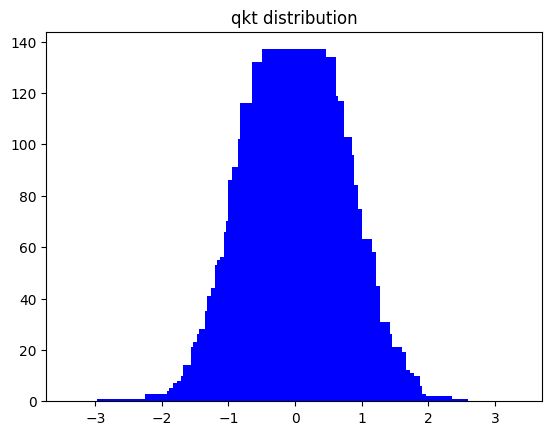

In [22]:
import matplotlib.pyplot as plt
y_val=torch.histc(qkv, bins=200, min=-3, max=3)
x_val=np.arange(-1,1,0.01)*3
plt.bar(x_val,y_val,align='center',color=['blue'])
plt.title('qkt distribution')

In [27]:
num_heads=8
head_dim=d_model//num_heads
qkv=qkv.reshape(batch_size,sequence_length,num_heads,3*head_dim)

In [28]:
qkv.shape

torch.Size([1, 4, 8, 192])

In [33]:
qkv=qkv.permute(0,2,1,3)
qkv.shape

torch.Size([1, 8, 4, 192])

In [34]:
q,k,v=qkv.chunk(3, dim=-1)
q.shape, k.shape, v.shape

(torch.Size([1, 8, 4, 64]),
 torch.Size([1, 8, 4, 64]),
 torch.Size([1, 8, 4, 64]))

In [35]:
d_k=q.size()[-1]
scaled=torch.matmul(q, k.transpose(-2,-1))/math.sqrt(d_k)
scaled.shape

torch.Size([1, 8, 4, 4])

In [41]:
mask=torch.full(scaled.size(),float('-inf'))
mask=torch.triu(mask,diagonal=1)
mask.shape
mask[0][4]

tensor([[0., -inf, -inf, -inf],
        [0., 0., -inf, -inf],
        [0., 0., 0., -inf],
        [0., 0., 0., 0.]])

In [43]:
(scaled+mask)[0][5]

tensor([[ 0.3849,    -inf,    -inf,    -inf],
        [-0.9217, -0.1210,    -inf,    -inf],
        [-0.4261, -0.0507,  0.7917,    -inf],
        [ 0.1539,  0.0894, -0.6801, -0.0210]], grad_fn=<SelectBackward0>)

In [44]:
scaled+=mask

In [46]:
attention=F.softmax(scaled,dim=-1)

In [48]:
attention[0][0]

tensor([[1.0000, 0.0000, 0.0000, 0.0000],
        [0.3017, 0.6983, 0.0000, 0.0000],
        [0.3280, 0.3957, 0.2764, 0.0000],
        [0.2450, 0.2189, 0.2542, 0.2819]], grad_fn=<SelectBackward0>)

In [49]:
values=torch.matmul(attention,v)
values.shape

torch.Size([1, 8, 4, 64])

In [57]:
import math 
def scaled_dot_product_attention(q,k,v, mask=None):
    d_k=q.size()[-1]
    scaled= torch.matmul(q,k.transpose(-2,-1)) / math.sqrt(d_k)
    if mask is not None:
        scaled+=mask
    attention=F.softmax(scaled, dim=-1)
    out=torch.matmul(attention,v)
    return out, attention

In [63]:
values, attention = scaled_dot_product_attention(q,k,v,mask=mask)

In [59]:
attention.shape

torch.Size([1, 8, 4, 4])

In [61]:
values, attention= scaled_dot_product_attention(q,k,v,mask=None)

In [64]:
attention[0][0]

tensor([[1.0000, 0.0000, 0.0000, 0.0000],
        [0.3017, 0.6983, 0.0000, 0.0000],
        [0.3280, 0.3957, 0.2764, 0.0000],
        [0.2450, 0.2189, 0.2542, 0.2819]], grad_fn=<SelectBackward0>)

In [65]:
values.size()

torch.Size([1, 8, 4, 64])

In [66]:
values=values.reshape(batch_size, sequence_length, num_heads*head_dim)
values.size()

torch.Size([1, 4, 512])

In [68]:
linear_layer=nn.Linear(d_model,d_model)

In [69]:
out=linear_layer(values)

In [70]:
out.shape

torch.Size([1, 4, 512])

In [71]:
class MultiheadAttention(nn.Module):
    
    def __init__(self, input_dim, d_model, num_heads):
        super().__init__()
        self.input_dim = input_dim
        self.d_model= d_model
        self.num_heads= num_heads
        self.head_dim = d_model//num_heads
        self.qkv_layer = nn.Linear(input_dim, 3*d_model)
        self.linear_layer = nn.Linear(d_model,d_model)
        
    def forward(self, x, mask=None):
        batch_size, sequence_length, input_dim = x.size()
        print(f"x.size(): {x.size()}")
        qkv=self.qkv_layer(x)
        print(f"qkv.size(): {qkv.size()}")
        qkv=qkv.reshape(batch_size,sequence_length,self.num_heads, 3*self.head_dim)
        print(f"qkv.size(): {qkv.size()}")
        qkv=qkv.permute(0,2,1,3)
        print(f"qkv.size(): {qkv.size()}")
        q,k,v = qkv.chunk(3, dim=-1)
        print(f"q.size(): {q.size()},k.size(): {k.size()},v.size(): {v.size()}")
        values, attention = scaled_dot_product_attention(q,k,v,mask)
        print(f"values.size(): {values.size()},attention.size(): {attention.size()}")
        values = values.reshape(batch_size, sequence_length, self.num_heads*self.head_dim)
        print(f"values.size(): {values.size()}")
        out=self.linear_layer(values)
        print(f"out.size(): {out.size()}")
        return out

In [73]:
input_dim=1024
d_model=512
num_heads=8

batch_size=30
sequence_length=5
x=torch.randn((batch_size,sequence_length,input_dim))

model= MultiheadAttention(input_dim,d_model,num_heads)
out=model.forward(x)

x.size(): torch.Size([30, 5, 1024])
qkv.size(): torch.Size([30, 5, 1536])
qkv.size(): torch.Size([30, 5, 8, 192])
qkv.size(): torch.Size([30, 8, 5, 192])
q.size(): torch.Size([30, 8, 5, 64]),k.size(): torch.Size([30, 8, 5, 64]),v.size(): torch.Size([30, 8, 5, 64])
values.size(): torch.Size([30, 8, 5, 64]),attention.size(): torch.Size([30, 8, 5, 5])
values.size(): torch.Size([30, 5, 512])
out.size(): torch.Size([30, 5, 512])
